In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np


import torch.nn.functional as F

In [2]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)  # chnl-in, out, krnl
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(1024, 512)   # [64*4*4, x]
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)     # 10 classes
        self.pool1 = nn.MaxPool2d(2, 2)   # kernel, stride
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.50)


    def forward(self, x):

        z = torch.relu(self.conv1(x))   # Size([bs, 32, 24, 24])
        z = self.pool1(z)           # Size([bs, 32, 12, 12])
        z = self.drop1(z)
        z = torch.relu(self.conv2(z))   # Size([bs, 64, 8, 8])
        z = self.pool2(z)           # Size([bs, 64, 4, 4])
    
        # neural network phase
        z = z.reshape(-1, 1024)     # Size([bs, 1024])
        z = torch.relu(self.fc1(z))     # Size([bs, 512])
        z = self.drop2(z)
        z = torch.relu(self.fc2(z))     # Size([bs, 256])
        z = self.fc3(z)             # Size([bs, 10])
        return z

In [3]:
def calculate_metrics(loader: DataLoader, model: nn.Module):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, recall, precision, f1

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=True, download=True, transform=transform)
valset = torchvision.datasets.FashionMNIST(root='./data_dz2', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)


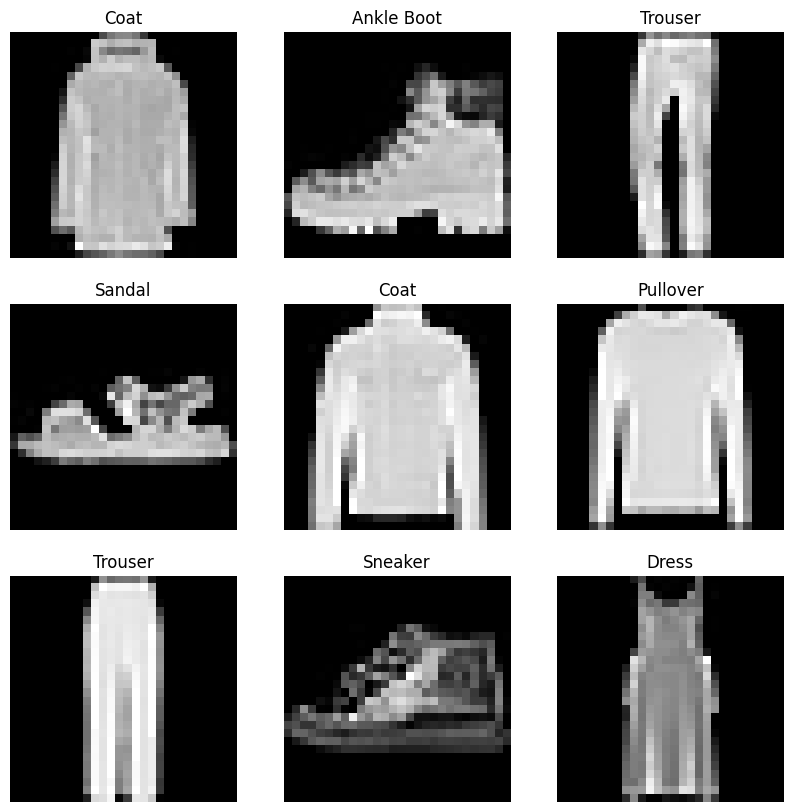

In [5]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(trainset), size = (1,)).item()
    image, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [6]:
net = SimpleNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

val_acc, val_rec, val_prec, val_f1 =0,0,0,0
epoch = 0


while val_acc < 0.95 and val_rec < 0.95 and val_prec < 0.95 and val_f1 < 0.95:
    
    running_loss = 0.0
    net.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss:nn.CrossEntropyLoss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.3f}')

    train_acc, train_rec, train_prec, train_f1 = calculate_metrics(trainloader, net)
    print(f'Training - Accuracy: {train_acc}, Recall: {train_rec}, Precision: {train_prec}, F1 Score: {train_f1}')

    val_acc, val_rec, val_prec, val_f1 = calculate_metrics(valloader, net)
    print(f'Validation - Accuracy: {val_acc}, Recall: {val_rec}, Precision: {val_prec}, F1 Score: {val_f1}')

    epoch+=1

print('Finished Training')

Epoch 1, Loss: 0.830
Training - Accuracy: 0.7807166666666666, Recall: 0.7807166666666667, Precision: 0.7879850210261198, F1 Score: 0.7747286169664873
Validation - Accuracy: 0.7729, Recall: 0.7729, Precision: 0.7828555447613044, F1 Score: 0.7681376037965226
Epoch 2, Loss: 0.480
Training - Accuracy: 0.8184, Recall: 0.8184000000000001, Precision: 0.8452140158762849, F1 Score: 0.7991265420386678
Validation - Accuracy: 0.8089, Recall: 0.8089000000000001, Precision: 0.832064495681146, F1 Score: 0.7891546381371046
Epoch 3, Loss: 0.396
Training - Accuracy: 0.8694666666666667, Recall: 0.8694666666666666, Precision: 0.8737981418775755, F1 Score: 0.8682112853699181
Validation - Accuracy: 0.8607, Recall: 0.8606999999999999, Precision: 0.8652780400689488, F1 Score: 0.8597431260027966
Epoch 4, Loss: 0.354
Training - Accuracy: 0.8873333333333333, Recall: 0.8873333333333333, Precision: 0.8896405717006803, F1 Score: 0.8862039121946965
Validation - Accuracy: 0.8786, Recall: 0.8785999999999999, Precision

KeyboardInterrupt: 

In [ ]:
torch.save(net, './saved_models/')